# PowerModelsDistribution.jl Transformer Modelling Tutorial

# Introduction
While `PowerModelsDistribution.jl` allows great flexibility modelling power transformers with any number of windings taking into account the loss models for each winding, it can be overwhelming for starting users especially the gap between the intuitive "ENGINEERING" (OpenDSS) definition and the "MATHEMATICAL" decomposition. Hence, this tutorial is to provide a simple introduction to power transformer models in `PowerModelsDistribution.jl`. 

For transformer model implementation details refer to *S. Claeys, G. Deconinck and F. Geth, “Decomposition of n-winding transformers for unbalanced optimal power flow,” IET Generation, Transmission & Distribution, vol. 14, no. 24, pp. 5961-5969, 2020, DOI: 10.1049/iet-gtd.2020.0776.*


# Transformer Modelling Theory

Starting with the simplest case of a two-winding, single-phase transformer, which will later serve as the fundamental building block for $n$-winding, $n$-phase transformers.

Without delving deeply into the electromagnetic theory of transformer operation, the functioning of a transformer can be simplified as follows: a primary coil (coil 1) and a secondary coil (coil 2) are wound on the same magnetic core. When a voltage $U_1$ is applied to the primary coil, it generates a magnetic flux $\Phi_1$. Part of this flux links the primary coil with itself (not going through the core to the secondary coil), denoted as $\Phi_{11}$, while another part, denoted as $\Phi_{m}$, links the secondary coil. The magnetic flux $\Phi_{m}$ induces a voltage $U_2$ in the secondary coil, which can drive a current $I_2$ when a load is connected to the secondary coil.



Taking into account that each of the coils has a resistance $R_1$ and $R_2$ and modelling the leakage flux $\Phi_{11}$ and $\Phi_{22}$ the transformer equivalent circuit can be represented as follows using basic circuit elements and an ideal transformer:



For a simpler schematic representation, we use a standarized symbol for the ideal transformer, note the polarity dots indicating that the two coil ends with dots will have the same instantaneous polarity.

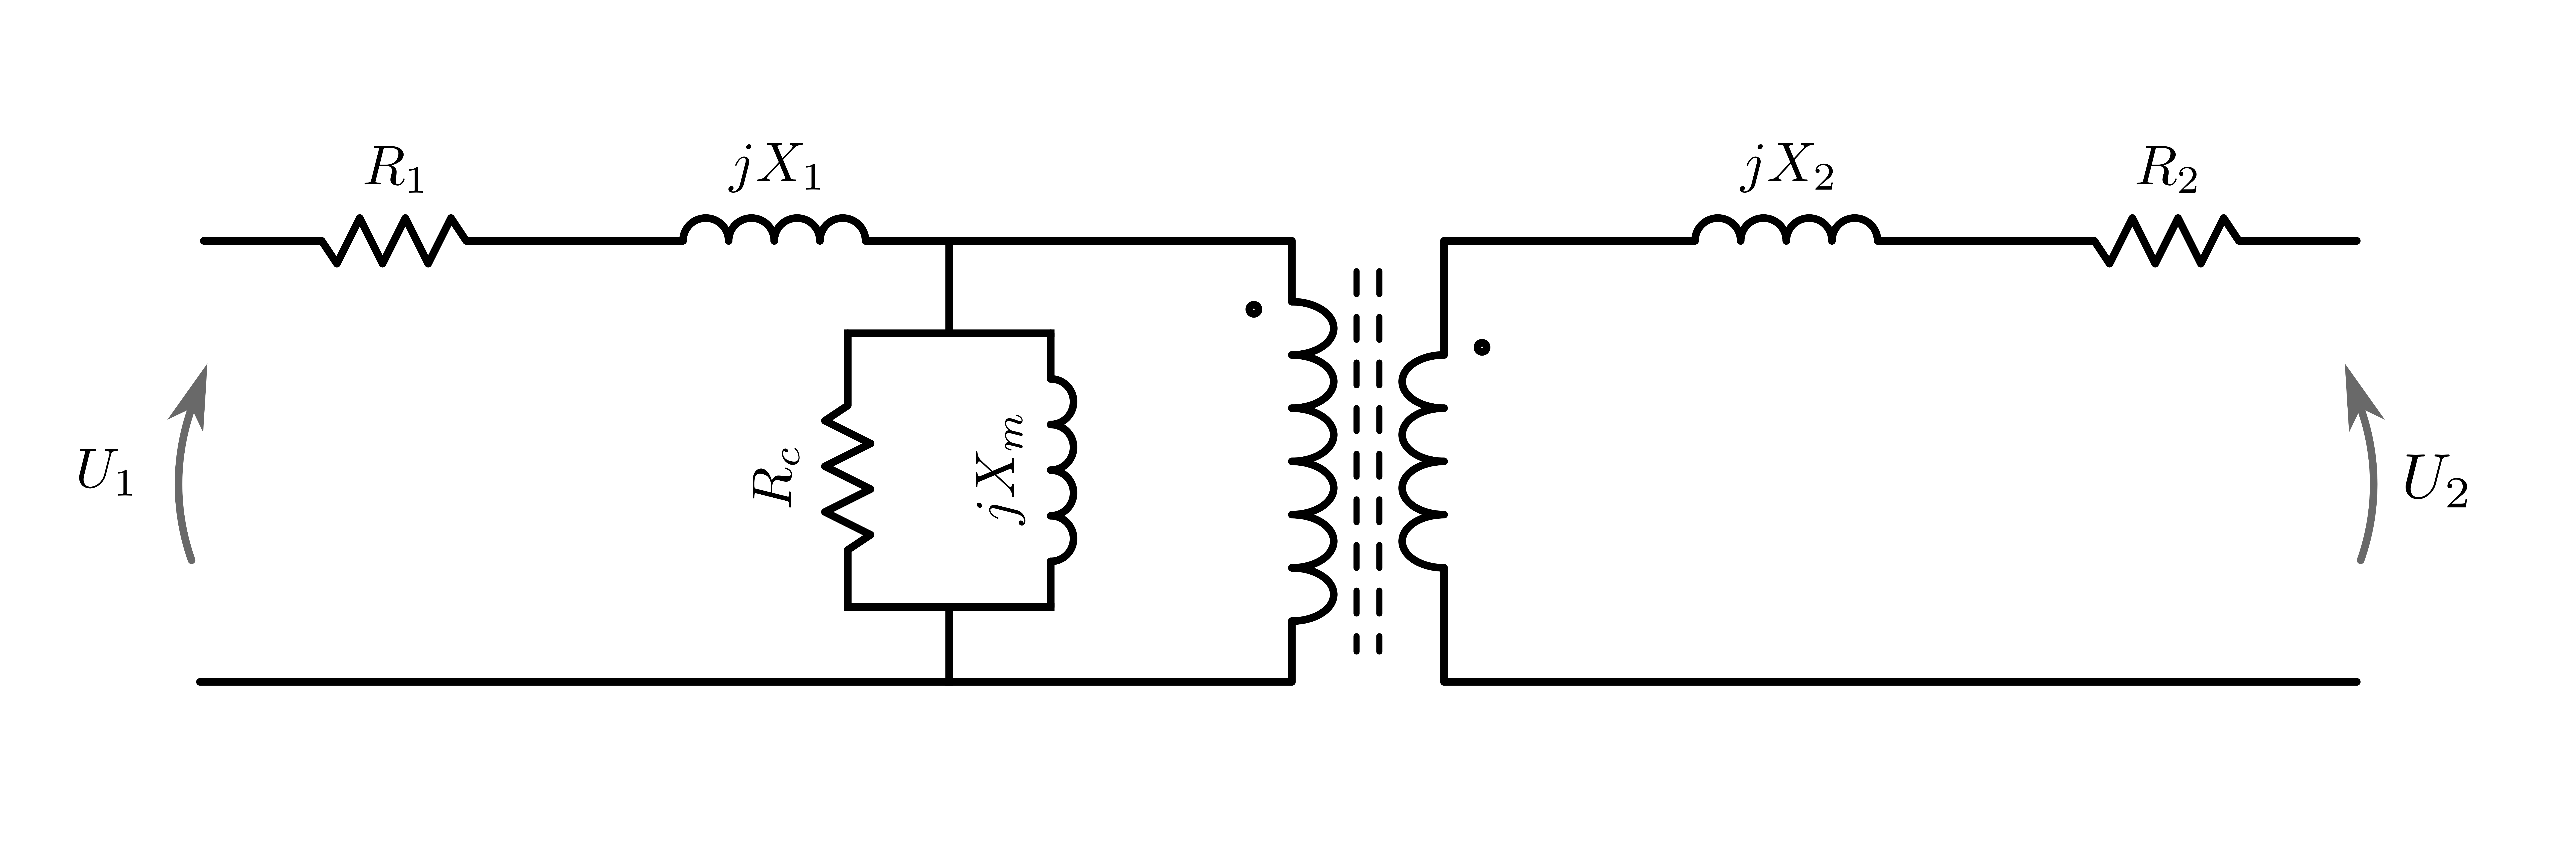


package_name = "PowerModelsDistribution"
eval(Meta.parse("using $package_name"))elsDistribution.jl
## Getting Started
In order to understand how does `PowerModelsDistribution.jl` model transformers, first we activate a Julia project in the current directory and we define [some helper functions](pmd_xfmr_modelling_helper_funs.jl) that we will need later on in this tutorial.

In [782]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

dependencies = ["PowerModelsDistribution", "Ipopt", "Makie", "CairoMakie"]
for dependency in dependencies
    if !(dependency in keys(Pkg.project().dependencies))
        Pkg.add(dependency)
    end
end

using PowerModelsDistribution
using Ipopt
using Makie
using CairoMakie
include("pmd_xfmr_modelling_helper_funs.jl")

  Activating project at `c:\Users\mnumair\OneDrive - KU Leuven\PhD Agenda\2025\12-25 December\PMD Transformer Model Tutorial`


analyze_vector_group

## DSS transformer definition

We then parse the [`trans_1ph_2w_yy.dss`](trans_1ph_2w_yy.dss) file which simply a single-phase source connected to a single-phase load through a two-winding, single-phase wye-wye transformer `TX1` which is defined as follows: 

```pascal
// ...
// Transformers
New Transformer.TX1 phases=1 Buses=[1 2]  // (required) Define transformer named TX1 connecting buses 1 and 2
~ windings=2  // (optional) Number of windings in the transformer
~ conns=[wye wye]  // (optional) Connection type for each winding (default: wye)
~ kvs=[11 0.4]  // (required) Rated voltage in kV for each winding
~ kvas=[500 500]  // (required) Rated power in kVA for each winding
~ xhl=5  // (optional) Leakage reactance between primary and secondary in percent (default: 2)
~ %noloadloss=5  // (optional) No-load loss as percentage of rated power (default: 0)
~ %imag=11  // (optional) Magnetizing current as percentage of rated current (default: 0)
~ wdg=1 %r=1  // (optional) Resistance of winding 1 as percentage of rated power (default: 0.002)
~ wdg=2 %r=2  // (optional) Resistance of winding 2 as percentage of rated power (default: 0.002)
// %r = [1 2] ! is also valid syntax
~ taps=[1.05 0.95]  // (optional) Tap position for each winding as per-unit voltage (default: 1.0)
~ leadlag=lead  // (optional) Phase shift direction for Dy/Yd transformers: lead or lag (default: lag)
~ bank=TX1  // (optional) Bank name for grouping transformers (default: transformer name)
// ...
```

While I have tried to add most used parameters, a lot of these parameters are optional and have default values. For a full list of parameters please refer to the [OpenDSS documentation](https://opendss.epri.com/Properties16.html).

## ENGINEERING model output
Now we will parse this `dss` file to the `ENGINEERING` model in `PowerModelsDistribution.jl` and inspect the transformer model.

In [783]:
eng_1ph_2w_yy = parse_file("trans_1ph_2w_yy.dss", transformations=[transform_loops!] );
eng_1ph_2w_yy["transformer"]["tx1"]

Dict{String, Any} with 18 entries:
  "polarity"      => [1, 1]
  "sm_nom"        => [500.0, 500.0]
  "connections"   => [[1, 4], [1, 4]]
  "tm_lb"         => [[0.9], [0.9]]
  "tm_set"        => [[1.05], [0.95]]
  "tm_step"       => [[0.03125], [0.03125]]
  "bus"           => ["b1", "b2"]
  "configuration" => ConnConfig[WYE, WYE]
  "status"        => ENABLED
  "noloadloss"    => 0.05
  "xsc"           => [0.05]
  "cmag"          => 0.11
  "sm_ub"         => 750.0
  "source_id"     => "transformer.tx1"
  "rw"            => [0.01, 0.02]
  "tm_fix"        => Vector{Bool}[[1], [1]]
  "vm_nom"        => [11.0, 0.4]
  "tm_ub"         => [[1.1], [1.1]]

Note that all `TX1` transformer parameters defined in the dss file match the `ENGINEERING` model output. Only value difference you might notice is the loss model impedances being re-based from the transformer rating to the network base [as detailed here](https://github.com/lanl-ansi/PowerModelsDistribution.jl/blob/79874bc491e9b2e71adb09bea79f227f33a99a72/src/data_model/transformations/dss2eng.jl#L554-L748). Additionally `PowerModelsDistribution.jl` adds default values for upper and lower bounds for some parameters if not defined in the dss file.


## MATHEMATICAL model output
Now we will transform the user-friendly `ENGINEERING` model into the optimization-ready `MATHEMATICAL` model in `PowerModelsDistribution.jl` and inspect the transformer model.

In `PowerModelsDistribution.jl`, the two-winding, single-phase transformer is modelled by decomposing it into two ideal transformers connected in series with the loss model virtual branches as shown below:

comparing to the generic equivalent circuit shown earlier, we can point out some key observations:
- in the `MATHEMATICAL` model, a single transformer is decomposed into two ideal transformers, each representing one winding of the original transformer.
- Due to this decomposition, there exists a third intermediate loss model at a voltage base of $1~\text{kV}$ between the two ideal transformers which are under their respective winding voltage bases.
- Loss model components are implemented as virtual branches using the internal "branch" data structure in `PowerModelsDistribution.jl`. Consequently, the parallel core loss and magnetizing components are modeled as shunt conductance ($G$) and susceptance ($B$) within the first virtual branch of the equivalent circuit.
- The series reactances ($X_1$, $X_2$) are added together in the middle (third) virtual branch of the `MATHEMATICAL` equivalent circuit.
- The series resistances ($R_1$, $R_2$) are added to the respective virtual branches of each ideal transformer.
 

### Single-Phase Two-Winding Wye-Wye Transformer

We can validate these observations by inspecting how `TX1` transformer has been modelled in the `MATHEMATICAL` model output of `PowerModelsDistribution.jl`.

In [784]:
math_1ph_2w_yy = transform_data_model(eng_1ph_2w_yy);
math_1ph_2w_yy["transformer"]

Dict{String, Any} with 2 entries:
  "1" => Dict{String, Any}("source_id"=>"_virtual_transformer.transformer.tx1.1…
  "2" => Dict{String, Any}("source_id"=>"_virtual_transformer.transformer.tx1.2…

We already can notice that `TX1` transformer has been decomposed into two ideal transformers `tx1.1` and `tx1.2`.

In [785]:
tx_components = show_transformer_math_components(math_1ph_2w_yy);

"in the MATHEMATICAL model transformer tx1 was converted to: "

"================================branch 3================================"

Dict{String, Any} with 22 entries:
  "br_r"          => [0.12;;]
  "br_x"          => [0.0;;]
  "g_to"          => [0.0;;]
  "c_rating_a"    => [Inf]
  "vbase"         => 0.57735
  "source_id"     => "_virtual_branch.transformer.tx1_2"
  "br_status"     => 1
  "b_to"          => [0.0;;]
  "index"         => 3
  "tap"           => [1.0]
  "shift"         => [0.0]
  "f_connections" => [1]
  "name"          => "_virtual_branch.transformer.tx1_2"
  "switch"        => false
  "g_fr"          => [0.00833333;;]
  "b_fr"          => [-0.0183333;;]
  "t_connections" => [1]
  "f_bus"         => 6
  "t_bus"         => 5
  ⋮               => ⋮

"================================branch 4================================"

Dict{String, Any} with 22 entries:
  "br_r"          => [0.0;;]
  "br_x"          => [0.3;;]
  "g_to"          => [0.0;;]
  "c_rating_a"    => [Inf]
  "vbase"         => 0.57735
  "source_id"     => "_virtual_branch.transformer.tx1_3"
  "br_status"     => 1
  "b_to"          => [0.0;;]
  "index"         => 4
  "tap"           => [1.0]
  "shift"         => [0.0]
  "f_connections" => [1]
  "name"          => "_virtual_branch.transformer.tx1_3"
  "switch"        => false
  "g_fr"          => [0.0;;]
  "b_fr"          => [0.0;;]
  "t_connections" => [1]
  "f_bus"         => 7
  "t_bus"         => 5
  ⋮               => ⋮

"================================branch 5================================"

Dict{String, Any} with 22 entries:
  "br_r"          => [0.06;;]
  "br_x"          => [0.0;;]
  "g_to"          => [0.0;;]
  "c_rating_a"    => [Inf]
  "vbase"         => 0.57735
  "source_id"     => "_virtual_branch.transformer.tx1_1"
  "br_status"     => 1
  "b_to"          => [0.0;;]
  "index"         => 5
  "tap"           => [1.0]
  "shift"         => [0.0]
  "f_connections" => [1]
  "name"          => "_virtual_branch.transformer.tx1_1"
  "switch"        => false
  "g_fr"          => [0.0;;]
  "b_fr"          => [0.0;;]
  "t_connections" => [1]
  "f_bus"         => 8
  "t_bus"         => 7
  ⋮               => ⋮

"================================transformer 1================================"

Dict{String, Any} with 20 entries:
  "source_id"     => "_virtual_transformer.transformer.tx1.1"
  "t_connections" => [1]
  "f_bus"         => 4
  "polarity"      => 1
  "sm_ub"         => 0.75
  "cm_ub"         => Inf
  "tm_fix"        => Bool[1]
  "tm_lb"         => [0.9]
  "tm_set"        => [1.05]
  "t_vbase"       => 0.57735
  "tm_step"       => [0.03125]
  "t_bus"         => 8
  "f_connections" => [1]
  "configuration" => WYE
  "index"         => 1
  "name"          => "_virtual_transformer.tx1.1"
  "tm_nom"        => 1.0
  "status"        => 1
  "tm_ub"         => [1.1]
  "f_vbase"       => 6.35085

"================================transformer 2================================"

Dict{String, Any} with 20 entries:
  "source_id"     => "_virtual_transformer.transformer.tx1.2"
  "t_connections" => [1]
  "f_bus"         => 3
  "polarity"      => 1
  "sm_ub"         => 0.75
  "cm_ub"         => Inf
  "tm_fix"        => Bool[1]
  "tm_lb"         => [0.9]
  "tm_set"        => [0.95]
  "t_vbase"       => 0.57735
  "tm_step"       => [0.03125]
  "t_bus"         => 6
  "f_connections" => [1]
  "configuration" => WYE
  "index"         => 2
  "name"          => "_virtual_transformer.tx1.2"
  "tm_nom"        => 1.0
  "status"        => 1
  "tm_ub"         => [1.1]
  "f_vbase"       => 0.23094

From the above log of all the components that transformer `TX1` has been decomposed into, we can see that it fits the decomposition explained earlier as in the image below. Also, it can be shown that the parameters of the first ideal transformer includes the rating, tap, polarity and connection of a single winding (the HV winding in this case), while the second ideal transformer includes the parameters of the other winding (the LV winding in this case). The loss model parameters are now represented as series impedances connected to the ideal transformers.


This function also returns a dictionary of the components that can be explored further.

In [786]:
tx_components["tx1"]

Dict{String, Any} with 3 entries:
  "branches"     => Dict{String, Any}("4"=>Dict{String, Any}("br_r"=>[0.0;;], "…
  "buses"        => Dict{String, Any}("5"=>Dict{String, Any}("vm_pair_lb"=>Tupl…
  "transformers" => Dict{String, Any}("1"=>Dict{String, Any}("source_id"=>"_vir…

This decomposition approach was chosen to simplify the modelling for the optimization model to reuse the existing network elements and their mathematical formulations for any $n$-winding transformer.

### Three-Phase Two-Winding Delta-Wye Transformer
As mentioned earlier, the two-winding, single-phase transformer model serves as the fundamental building block for $n$-winding, $n$-phase transformers. Hence, we can extend the same understanding to a more complex transformer such as a three-phase, two-winding delta-wye transformer. as defined in the [`trans_3ph_2w_dy_en.dss`](trans_3ph_2w_dy_en.dss) file. In which the transformer `TX1` is defined as follows:

```pascal
// ...
New Transformer.TX1 phases=3 Buses=[b1.1.2.3 b2.1.2.3.4]
~ Windings=2
~ Conns=[Delta Wye]
~ kVs=[11 0.4]
~ kVAs=[500 500]
~ %Rs=[1 2]
~ xhl=5
~ %noloadloss=5
~ %imag=11
~ leadlag=lag
~ taps=[1.0 1.0]

New Reactor.Grounding phases=1 bus1=b2.4 bus2=b2.0 R=0 X=1E-6 // Grounding reactor for wye neutral
// ...
```

We can notice that in the three phase transformer definition, we have an additional parameter `phases=3` and we define the connection points for each winding in the `Buses` parameter as `b1.1.2.3` for the delta primary winding and `b2.1.2.3.4` for the wye secondary winding with the fourth point being the neutral point which is grounded through a the `Grounding` reactor defined later.  



In [787]:
eng_3ph_2w_dy = parse_file("trans_3ph_2w_dy_en.dss", transformations=[transform_loops!] );
eng_3ph_2w_dy["transformer"]["tx1"]

Dict{String, Any} with 19 entries:
  "polarity"      => [1, -1]
  "sm_nom"        => [500.0, 500.0]
  "tm_lb"         => [[0.9, 0.9, 0.9], [0.9, 0.9, 0.9]]
  "connections"   => [[1, 2, 3], [2, 3, 1, 4]]
  "tm_set"        => [[1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]
  "tm_step"       => [[0.03125, 0.03125, 0.03125], [0.03125, 0.03125, 0.03125]]
  "bus"           => ["b1", "b2"]
  "configuration" => ConnConfig[DELTA, WYE]
  "name"          => "tx1"
  "status"        => ENABLED
  "noloadloss"    => 0.05
  "cmag"          => 0.11
  "xsc"           => [0.05]
  "source_id"     => "transformer.tx1"
  "sm_ub"         => 750.0
  "rw"            => [0.01, 0.02]
  "tm_fix"        => Vector{Bool}[[1, 1, 1], [1, 1, 1]]
  "vm_nom"        => [11.0, 0.4]
  "tm_ub"         => [[1.1, 1.1, 1.1], [1.1, 1.1, 1.1]]

As in the single-phase case, we can validate that the parameters have been parsed correctly in the `ENGINEERING` model output. And now we can inspect how has the three-phase, two-winding delta-wye transformer `TX1` been modelled in the `MATHEMATICAL` model output of `PowerModelsDistribution.jl`.

In [788]:
math_3ph_2w_dy = transform_data_model(eng_3ph_2w_dy, kron_reduce=false, phase_project=false);

Note that in this conversion we set the options `kron_reduce=false` and `phase_project=false` to keep all phases and neutral in the mathematical model for inspection purposes. However, it is possible to apply Kron reduction and phase projection during the transformation to eliminate the neutral and reduce the model.

Now if we inpsect the components that transformer `TX1` has been decomposed into, we can see that it exactly matches that for the single-phase case but now with full matrices for the loss model's virtual branches parameters as shown below: 

In [789]:
tx_components = show_transformer_math_components(math_3ph_2w_dy);

"in the MATHEMATICAL model transformer tx1 was converted to: "

"================================branch 3================================"

Dict{String, Any} with 22 entries:
  "br_r"          => [0.024 0.0 0.0; 0.0 0.024 0.0; 0.0 0.0 0.024]
  "br_x"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "g_to"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "c_rating_a"    => [Inf, Inf, Inf]
  "vbase"         => 0.57735
  "source_id"     => "_virtual_branch.transformer.tx1_2"
  "br_status"     => 1
  "b_to"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "index"         => 3
  "tap"           => [1.0, 1.0, 1.0]
  "shift"         => [0.0, 0.0, 0.0]
  "f_connections" => [1, 2, 3]
  "name"          => "_virtual_branch.transformer.tx1_2"
  "switch"        => false
  "g_fr"          => [0.0416667 0.0 0.0; 0.0 0.0416667 0.0; 0.0 0.0 0.0416667]
  "b_fr"          => [-0.0916667 0.0 0.0; 0.0 -0.0916667 0.0; 0.0 0.0 -0.091666…
  "t_connections" => [1, 2, 3]
  "f_bus"         => 6
  "t_bus"         => 5
  ⋮               => ⋮

"================================branch 4================================"

Dict{String, Any} with 22 entries:
  "br_r"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "br_x"          => [0.06 0.0 0.0; 0.0 0.06 0.0; 0.0 0.0 0.06]
  "g_to"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "c_rating_a"    => [Inf, Inf, Inf]
  "vbase"         => 0.57735
  "source_id"     => "_virtual_branch.transformer.tx1_3"
  "br_status"     => 1
  "b_to"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "index"         => 4
  "tap"           => [1.0, 1.0, 1.0]
  "shift"         => [0.0, 0.0, 0.0]
  "f_connections" => [1, 2, 3]
  "name"          => "_virtual_branch.transformer.tx1_3"
  "switch"        => false
  "g_fr"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "b_fr"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "t_connections" => [1, 2, 3]
  "f_bus"         => 7
  "t_bus"         => 5
  ⋮               => ⋮

"================================branch 5================================"

Dict{String, Any} with 22 entries:
  "br_r"          => [0.012 0.0 0.0; 0.0 0.012 0.0; 0.0 0.0 0.012]
  "br_x"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "g_to"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "c_rating_a"    => [Inf, Inf, Inf]
  "vbase"         => 0.57735
  "source_id"     => "_virtual_branch.transformer.tx1_1"
  "br_status"     => 1
  "b_to"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "index"         => 5
  "tap"           => [1.0, 1.0, 1.0]
  "shift"         => [0.0, 0.0, 0.0]
  "f_connections" => [1, 2, 3]
  "name"          => "_virtual_branch.transformer.tx1_1"
  "switch"        => false
  "g_fr"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "b_fr"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "t_connections" => [1, 2, 3]
  "f_bus"         => 8
  "t_bus"         => 7
  ⋮               => ⋮

"================================transformer 1================================"

Dict{String, Any} with 20 entries:
  "source_id"     => "_virtual_transformer.transformer.tx1.1"
  "t_connections" => [1, 2, 3, 4]
  "f_bus"         => 4
  "polarity"      => 1
  "sm_ub"         => 3.75
  "cm_ub"         => Inf
  "tm_fix"        => Bool[1, 1, 1]
  "tm_lb"         => [0.9, 0.9, 0.9]
  "tm_set"        => [1.0, 1.0, 1.0]
  "t_vbase"       => 0.57735
  "tm_step"       => [0.03125, 0.03125, 0.03125]
  "t_bus"         => 8
  "f_connections" => [1, 2, 3]
  "configuration" => DELTA
  "index"         => 1
  "name"          => "_virtual_transformer.tx1.1"
  "tm_nom"        => 1.73205
  "status"        => 1
  "tm_ub"         => [1.1, 1.1, 1.1]
  "f_vbase"       => 6.35085

"================================transformer 2================================"

Dict{String, Any} with 20 entries:
  "source_id"     => "_virtual_transformer.transformer.tx1.2"
  "t_connections" => [1, 2, 3, 4]
  "f_bus"         => 3
  "polarity"      => -1
  "sm_ub"         => 3.75
  "cm_ub"         => Inf
  "tm_fix"        => Bool[1, 1, 1]
  "tm_lb"         => [0.9, 0.9, 0.9]
  "tm_set"        => [1.0, 1.0, 1.0]
  "t_vbase"       => 0.57735
  "tm_step"       => [0.03125, 0.03125, 0.03125]
  "t_bus"         => 6
  "f_connections" => [2, 3, 1, 4]
  "configuration" => WYE
  "index"         => 2
  "name"          => "_virtual_transformer.tx1.2"
  "tm_nom"        => 1.0
  "status"        => 1
  "tm_ub"         => [1.1, 1.1, 1.1]
  "f_vbase"       => 0.23094

Additionally, we can see that each ideal transformer has a `"configuration"` parameter indicating the connection type of that winding (delta or wye), which is used alongside the `"polarity"` and `"f_connection"` and `"t_connection"` parameters to achieve the correct phase shift (vector group) and connection type in the mathematical model as will be discussed in the next section.

# Transformer Vector Groups

In three-phase power systems, transformers can connect the primary and secondary windings in different configurations (Wye, Delta, Zigzag, etc.). The combination of connection types and the resulting phase shift between the high-voltage (HV) and low-voltage (LV) sides is described by the **Vector Group**.

## The "Clock" Notation
The vector group is usually denoted by a code such as **Dyn11**. This acts like a clock face:
*   **D**: Capital letter indicates the High Voltage (HV) winding connection (D = Delta, Y = Wye, Z = Zigzag).
*   **y**: Lowercase letter indicates the Low Voltage (LV) winding connection (d = Delta, y = Wye, z = Zigzag).
*   **n**: Indicates if the Neutral is brought out.
*   **11**: The "Clock Number" representing the phase shift.

The phase shift is measured in units of 30 degrees (the angle between hours on a clock). **The HV phasor is always the reference at 12 o'clock (0°).**

| Clock | Angle | Description |
| :--- | :--- | :--- |
| **0** | $0^\circ$ | In-phase |
| **1** | $-30^\circ$ | Lagging by 30° |
| **6** | $180^\circ$ | Opposite |
| **11** | $+30^\circ$ | Leading by 30° |

### Achieving Different Vector Groups
In physical transformers (and `PowerModelsDistribution.jl`), different vector groups are achieved by:
1.  **Connection Type**: Delta or Wye.
2.  **Polarity**: Reversing the winding polarity (adds 180° shift).
3.  **Phase Sequence (Permutation)**: Swapping how the phases (A, B, C) are connected to the terminals. For example, connecting phase A to terminal C and C to A on a Delta winding effectively reverses the sequence, turning a Lag into a Lead.

We will now explore this interactively. You can change the connections and wiring permutations below and see the **actual phase shift** produced by the math model.

In [790]:
# Configuration Options
primary_perms = [
    [1, 2, 3], [1, 3, 2], [2, 1, 3], 
    [2, 3, 1], [3, 1, 2], [3, 2, 1]
]

secondary_perms = [
    [1, 2, 3], [1, 3, 2], [2, 1, 3], 
    [2, 3, 1], [3, 1, 2], [3, 2, 1]
]

lead_lag_opts = ["Lead", "Lag"]
conn_opts = [
    ("Delta", "Wye"), 
    ("Wye", "Wye"), 
    ("Wye", "Delta"), 
    ("Delta", "Delta")
]

4-element Vector{Tuple{String, String}}:
 ("Delta", "Wye")
 ("Wye", "Wye")
 ("Wye", "Delta")
 ("Delta", "Delta")

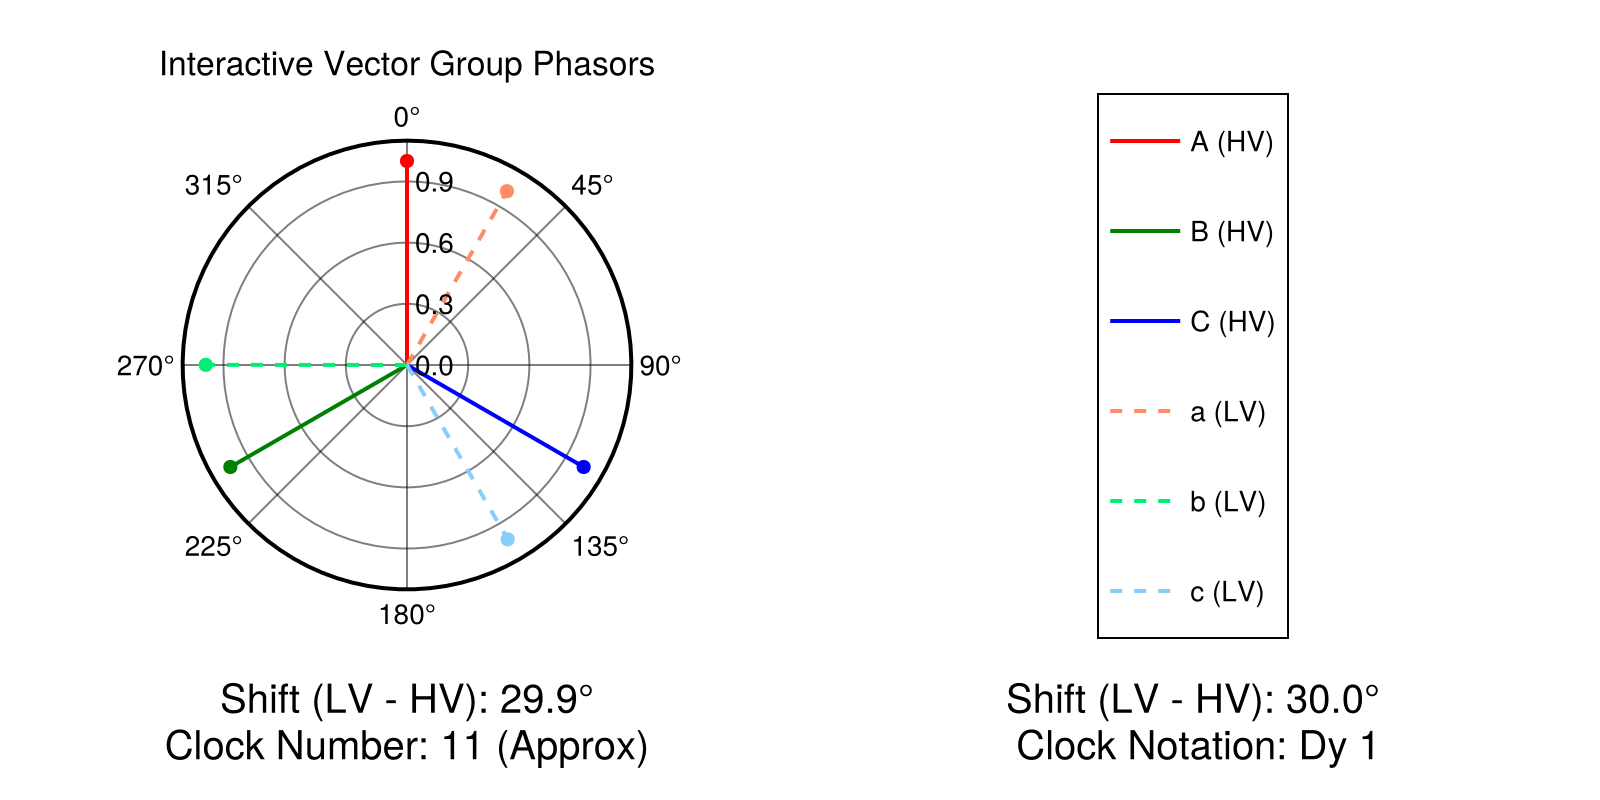

In [791]:
# INTERACTIVE: Change these values and Run this cell!
# =======================================================

# 1. Choose Connection Pair (Primary, Secondary)
# Options: ("Delta", "Wye"), ("Wye", "Wye"), ("Wye", "Delta"), ("Delta", "Delta")
selected_conn = ("Delta", "Wye") 

# 2. Choose Wira Permutations [1, 2, 3] is standard A-B-C
# Try [1, 3, 2] to swap B and C phases!
sel_prim_perm = [1, 2, 3] 
sel_sec_perm  = [1, 2, 3]

# 3. OpenDSS Lead/Lag setting (Only affects D-y or Y-d)
# Options: "Lead", "Lag"
sel_lead_lag = "Lead"


# 4. Choose Taps [Primary, Secondary] (p.u.)
selected_taps = [1.0, 1.0]



# =======================================================
# Run Simulation
analyze_vector_group(
    selected_conn[1], selected_conn[2], 
    sel_prim_perm, sel_sec_perm, 
    sel_lead_lag, selected_taps
);

## 5. Summary of Reachable Groups

By changing the connection permutation (cyclic rotation) of the terminals 1, 2, 3:

1.  **Group 0 (0, 4, 8):** Obtained from **Dd / Yy** types.
2.  **Group 1 (1, 5, 9):** Obtained from **Dy / Yd** types (lagging connection).
3.  **Group 11 (11, 3, 7):** Obtained from **Dy / Yd** types (leading connection).
4.  **Group 6 (6, 10, 2):** Obtained by reversing polarity of coils (Swapping ends of windings, e.g., connecting a' to Neutral instead of n').

A list of all reachable vector groups is available in [Appendix A](AppendixA_vector_groups.md)
*Note: Currently PowerModelsDistribution has an issue with Delta winding as a secondary, I am trying to fix it.*
*Note: In OpenDSS/PowerModelsDistribution, defining `Buses=[... 3.1.2]` performs these cyclic shifts that is simulated by the `leadlag` parameter in OpenDSS*

